In [7]:
import itertools
import json
import time

import gym
import tqdm
from gym.envs.registration import register
register(
    id='D8x8-FrozenLake-v0',
    entry_point='gym.envs.toy_text.frozen_lake:FrozenLakeEnv',
    kwargs={'map_name': '8x8',
            'is_slippery': True})

D:\conda\MDP\lib\site-packages\gym\envs\registration.py:216: UserWarning: WARN: Overriding environment D8x8-FrozenLake-v0
  logger.warn("Overriding environment {}".format(id))


In [3]:
%matplotlib inline
import seaborn
import matplotlib.pyplot as plt
import numpy as np
import math
def fancy_visual(value_func,policy_int):    
    grid = 4
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = seaborn.diverging_palette(220, 10, as_cmap=True)
    reshaped=np.reshape(value_func,(grid,grid))
    seaborn.heatmap(reshaped, cmap=cmap, vmax=1.1,
                square=True, xticklabels=grid+1, yticklabels=grid+1,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, annot=True, fmt="f")
    counter=0
    for j in range(0, 8):
        for i in range(0, 8):
            if policy_int[counter]==1:
                plt.text(i+0.5, j+0.7, u'\u2193', fontsize=12)
            elif policy_int[counter]==3:
                plt.text(i+0.5, j+0.7, u'\u2191', fontsize=12)
            elif policy_int[counter]==0:
                plt.text(i+0.5, j+0.7, u'\u2190', fontsize=12)
            else:
                plt.text(i+0.5, j+0.7, u'\u2192', fontsize=12)
            counter=counter+1

    plt.title('Heatmap of policy iteration with value function values and directions')
    print('Value Function',value_func)
    print('Policy',policy_int)
    plt.show()

In [19]:
def policy_evaluation(policy, P, nS, max_iter=10000, epsilon=1e-6, gamma=0.9):
    V = np.zeros(nS)
    new_V = V.copy() # todo: double check if new_V should be here
    differences = []
    for i in range(max_iter):
        for s in range(nS):
            for prob, next_s, reward, terminal in P[s][policy[s]]:
                new_V[s] += prob * (reward + gamma * V[next_s])
        max_diff = np.max(np.abs(new_V-V))
        differences.append(max_diff)
        if max_diff < epsilon:
            break
        V = new_V
    return differences, new_V

def test_policy(env, policy, gamma,  n = 100):
    def run_episode(env, policy, gamma, render = False):
        """ Evaluates policy by using it to run an episode and finding its
        total reward.
        args:
        env: gym environment.
        policy: the policy to be used.
        gamma: discount factor.
        render: boolean to turn rendering on/off.
        returns:
        total reward: real value of the total reward recieved by agent under policy.
        """
        obs = env.reset()
        total_reward = 0
        step_idx = 0
        while True:
            if render:
                env.render()
            obs, reward, done , _ = env.step(int(policy[obs]))
            total_reward += (gamma ** step_idx * reward)
            step_idx += 1
            if done:
                break
        return total_reward
    scores = [
        run_episode(env, policy, gamma=gamma, render = False)
        for _ in range(n)]
    return np.mean(scores)

def policy_improvement(V, policy, P, nA, nS, gamma):
    for s in range(nS):
        new_v = [0]*nA
        for a in range(nA):
            for prob, next_s, reward, terminal in P[s][a]:
                new_v[a] += prob * (reward + gamma * V[next_s])
        policy[s] = np.argmax(new_v)
    return policy

def l2(a, b):
    s = 0
    for i in range(len(a)):
        s += (a[i]-b[i])**2
    return math.sqrt(s)

max_policy_iterations = [1e2, 1e4, 1e6]
gammas = [0.1, 0.6, 0.9]
epsilons = [0.1, 0.001, 0.00001]
n_iterations = [1e2, 1e3, 1e4]
hyperparameters = list(itertools.product(max_policy_iterations, gammas, epsilons, n_iterations))

def run():
    env = gym.make('D8x8-FrozenLake-v0')

    num_states = env.nS
    num_actions = env.nA

    for max_iterations, gamma, epsilon, n_iteration in tqdm.tqdm(hyperparameters, desc="Policy Iteration Experiment"):
        iteration_differences = []
        policy_eval_differences = []
        env.reset()
        policy = np.zeros(env.nS)
        start_time = time.process_time()
        differences, V = policy_evaluation(policy, env.P, env.nS, max_iter=int(max_iterations), epsilon=epsilon, gamma=gamma)
        policy_eval_differences.append(differences)
        for _ in range(int(n_iteration)):
            policy = policy_improvement(V, policy, env.P, num_actions, num_states, gamma=gamma)
            differences, new_V = policy_evaluation(policy, env.P, num_states, epsilon=epsilon, gamma=gamma)
            policy_eval_differences.append(differences)
            iteration_differences.append(l2(V, new_V))
            V = new_V
        wall_time = time.process_time() - start_time

        average_test_score = test_policy(env, policy, gamma)

        result = {
            'iteration_differences': iteration_differences,
            'policy_eval_differences': policy_eval_differences,
            'V': V.tolist(),
            'policy': policy.tolist(),
            'n_iterations': n_iteration,
            'gamma': gamma,
            'max_iterations': max_iterations,
            'epsilon': epsilon,
            'wall_time': wall_time,
            'average_test_score': average_test_score
        }

        with open(f'artifacts/pendulum_policy_iteration/{time.time_ns()}.json', 'w') as f:
            json.dump(result, f)

run()

Policy Iteration Experiment:   2%|▏         | 2/81 [00:04<03:01,  2.30s/it]


KeyboardInterrupt: 

Value Function [0.06888452 0.06140916 0.07440581 0.05580298 0.09184873 0.
 0.11220608 0.         0.14543165 0.24749378 0.29961536 0.
 0.         0.37993361 0.63901895 0.        ]
Policy [0, 3, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]


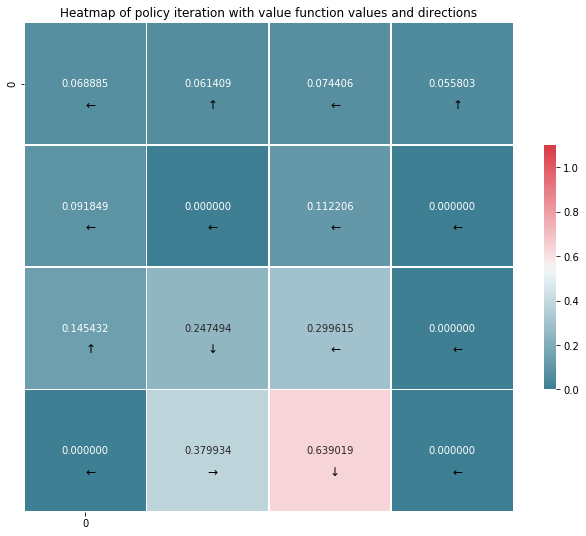


SFFF
FHFH
FFFH
HFFG


In [34]:
fancy_visual(V, policy)
env.render()

In [35]:
def q_func(V, P, nA, nS):
    q = np.zeros((nS, nA))
    for s in range(nS):
        for a in range(nA):
            for prob, next_s, reward, terminal in P[s][a]:
                q[s][a] += prob * (reward + gamma * V[next_s])
    return q

print('Optimal Q function')
q_func(V, env.P, env.nA, env.nS)

Optimal Q function


array([[0.06888533, 0.06664272, 0.06664272, 0.05975346],
       [0.0390881 , 0.0429871 , 0.04074449, 0.06140985],
       [0.07440632, 0.06882547, 0.07272446, 0.05748539],
       [0.03906264, 0.03906264, 0.03348179, 0.05580353],
       [0.09184947, 0.07118411, 0.06429485, 0.04821997],
       [0.        , 0.        , 0.        , 0.        ],
       [0.11220635, 0.08988461, 0.11220635, 0.02232174],
       [0.        , 0.        , 0.        , 0.        ],
       [0.07118411, 0.11787763, 0.10180275, 0.14543225],
       [0.15760958, 0.24749419, 0.20386469, 0.1335141 ],
       [0.29961565, 0.26595382, 0.22536751, 0.10790996],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.18822822, 0.30568577, 0.3799339 , 0.26595382],
       [0.39557038, 0.6390191 , 0.61492363, 0.53719803],
       [0.        , 0.        , 0.        , 0.        ]])